In [2]:
from tabula import read_pdf
import io
import os
import time
 
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


In [53]:
def extract_text_from_pdf(pdf_path):
    resource_manager = PDFResourceManager()
    fake_file_handle = io.StringIO()
    converter = TextConverter(resource_manager, fake_file_handle)
    page_interpreter = PDFPageInterpreter(resource_manager, converter)
 
    with open(pdf_path, 'rb') as fh:
        for page in PDFPage.get_pages(fh, 
                                      caching=True,
                                      check_extractable=True):
            page_interpreter.process_page(page)
 
        text = fake_file_handle.getvalue()
 
    # close open handles
    converter.close()
    fake_file_handle.close()
 
    if text:
        return text

def find_experiment_ID(text):
    field_length = 6
    field_title = "Sample Name:"
    field_index = text.find(field_title)
    field_found = text[(field_index + 13):(field_index + 13 + field_length)]
    if field_found[-1].isalpha():
        return field_found
    else:
        return field_found + text[field_index + 13 + field_length]

def parse_update_table(filename, experiment_ID):
    df = read_pdf(filename)
    df = df.rename(index=str, columns={'Unnamed: 0': 'experiment_id', 
                                   'Name': 'cannabinoid',
                                   'Calibration Id': 'calibration_id', 
                                   'Result Id': 'result_id'})
    df.experiment_id = experiment_ID
    return df

In [105]:
# %%time
counter = 0

directory_in_str = "/Users/orsegal/Dropbox/Panaxia/Indications/Anti-Inflammatory Experiment/Analytical Chemistry/HPLC Results/HPLC PDF"
directory = os.fsencode(directory_in_str)

start_time = time.time()
for file in os.listdir(directory):
    filename = directory_in_str + "/" + os.fsdecode(file)

    text = extract_text_from_pdf(filename)
    experiment_ID = find_experiment_ID(text)
    if counter == 0: 
        HPLC_results = parse_update_table(filename, experiment_ID)
    else:
        HPLC_results = pd.concat([HPLC_results, parse_update_table(filename, experiment_ID)], sort=False)
    counter += 1
    print("\rFinished {n_rows}/{tot_files} files. Time: {t:.2f}/~{ETA:.2f}"
          .format(n_rows=counter, tot_files=len(os.listdir(directory)),
                  t=time.time()-start_time, ETA=(4.48*90)), end="")
    
# HPLC_results.to_excel("HPLC_results.xlsx")

## NOTE
'''
After this point, I used Excel to remove the messy rows that were'nt read correctly.
'''

In [121]:
# Verify that all files are in the dataframe
results_in = HPLC_results.result_id.unique()
list_of_file_num = []
files_out = []
for i in range(len(os.listdir(directory))):
    list_of_file_num.append(int(os.listdir(directory)[i][5:10]))
#     print(list_of_file_num[-1])
    if not list_of_file_num[-1] in results_in:
        files_out.append(list_of_file_num[-1])

files_out


[]

In [164]:
HPLC_results = pd.read_excel("HPLC_results.xlsx")
HPLC_results.head()

,experiment_id,cannabinoid,Amount,Area,Height,RT,result_id
0,1-101,11-OH THC,0.070000,1.996650e+05,14010.000000,7.440500,12317.5
1,1-101,CBC,0.321000,1.683804e+06,126111.666667,18.896333,12318.0
2,1-101,CBD,2.366500,3.220576e+06,206583.500000,12.404500,12318.5
3,1-101,CBDA,0.041000,2.014123e+05,14148.333333,10.513333,12318.0
4,1-101,CBG,0.226333,5.633150e+05,37659.666667,11.824667,12318.0


In [186]:
cann_col = ["experiment_id"]
HPLC_exp = pd.DataFrame(columns=cann_col)
# HPLC_exp.set_index("experiment_id")

for index, row in HPLC_results.iterrows():
    if row["cannabinoid"] not in cann_col:
        cann_col.append(row["cannabinoid"])
        HPLC_exp[row["cannabinoid"]] = np.nan
        
    if row["experiment_id"] not in list(HPLC_exp["experiment_id"]):        
        HPLC_exp.loc[len(HPLC_exp)] = [np.nan for _ in range(len(HPLC_exp.columns))]
        HPLC_exp.loc[len(HPLC_exp) - 1, "experiment_id"] = row["experiment_id"]
    HPLC_exp.loc[HPLC_exp.experiment_id == row["experiment_id"], row["cannabinoid"]] = row["Amount"]
    


In [40]:
# HPLC_exp = HPLC_exp.rename(index=str, columns={'11-OH THC': '11-OH_THC', 'd-8 THC': "d-8_THC"})
# HPLC_exp.to_excel("HPLC_results_by_experiment.xlsx")


HPLC_exp = pd.read_excel("HPLC_results_by_experiment.xlsx")
HPLC_exp = HPLC_exp.drop(columns=["IBU"])
HPLC_exp = HPLC_exp.sort_values(by=['CBD', "THC"], ascending=False)
HPLC_exp = HPLC_exp.set_index("experiment_id")
HPLC_exp = HPLC_exp.reindex(HPLC_exp.mean().sort_values().index, axis=1)
HPLC_exp = HPLC_exp.loc[::,HPLC_exp.columns[::-1]]
HPLC_exp = HPLC_exp.drop(["1-103"], axis=0)
display(HPLC_exp)

,CBD,THC,CBDA,THCA,CBC,CBN,CBG,11-OH_THC,THCV,CBGA,d-8_THC
experiment_id,,,,,,,,,,,
12-247,19.724000,1.020000,0.069500,NaN,0.958500,0.073000,0.240500,0.348500,0.036500,0.0020,NaN
1-105,19.109000,0.770500,1.112000,NaN,0.891000,0.022000,0.308500,0.281000,0.153500,0.0140,NaN
12-249,18.725000,0.845500,0.235000,NaN,0.770500,0.008000,0.218000,0.260500,0.151000,0.0040,NaN
12-243,18.557000,0.625500,0.502500,0.2170,0.855000,0.089000,0.196500,0.311500,0.056500,0.0060,NaN
12-245,16.423000,0.812500,0.020000,NaN,0.917000,0.027000,0.303500,0.268500,0.202500,0.0030,NaN
1-102,8.485000,8.248000,0.055500,NaN,0.701000,0.118000,0.284500,0.125500,0.059000,0.0060,NaN
12-248,6.023000,0.822667,0.019000,NaN,0.323333,0.074333,0.126000,0.090333,0.027667,NaN,NaN
1-107,5.322000,0.219000,0.408500,NaN,0.397500,0.196000,0.187500,0.107500,0.081000,NaN,NaN
12-253,3.118000,8.309000,0.035000,0.0465,0.436500,0.165500,0.281000,0.050500,0.088000,0.0130,NaN


Text(0, 0.5, 'Concentration (%(w/w))')

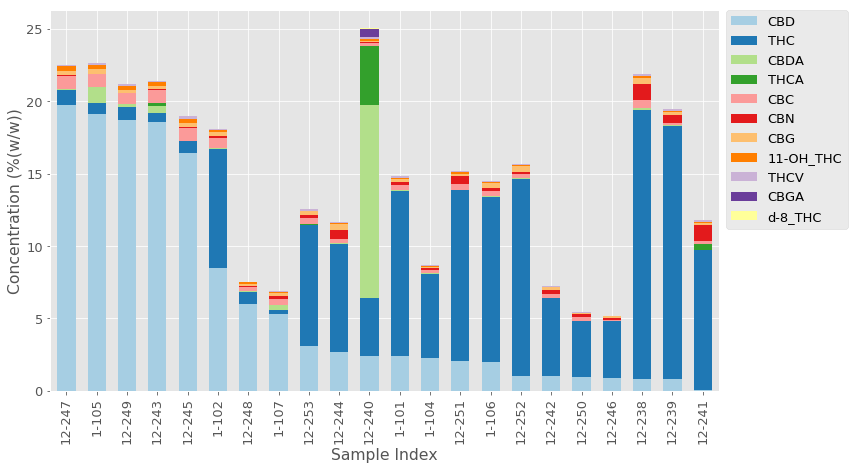

In [41]:

palette = plt.get_cmap('Paired')
colors = []
for i in range(11):
    colors.append(palette(i))
colors

fig, ax = plt.subplots(1,1, figsize=(12, 7))
HPLC_exp.plot(kind="bar", stacked=True, ax=ax, color=colors, width = 0.6)
ax.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0.)
ax.set_xlabel("Sample Index")
ax.set_ylabel("Concentration (%(w/w))")
# plt.savefig("HPLC_results.png", dpi=1000, bbox_inches='tight')#, bbox_extra_artist=[lgd])

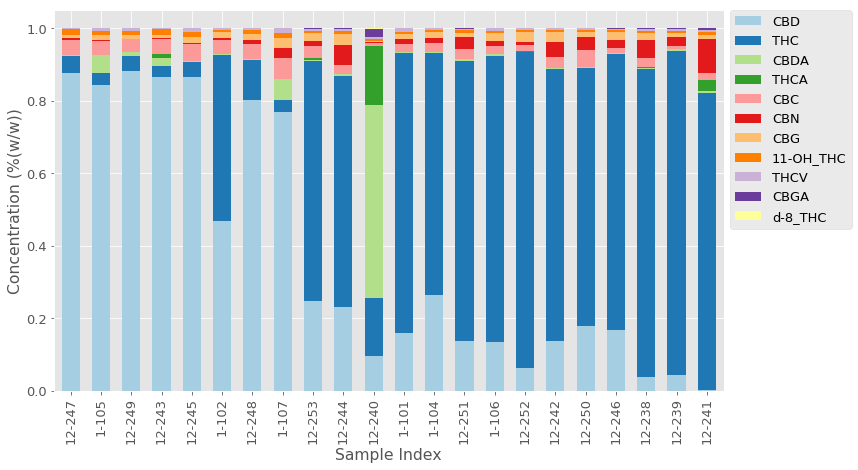

In [42]:
normed_HPLC_exp = HPLC_exp.div(HPLC_exp.sum(1), axis=0)

fig, ax = plt.subplots(1,1, figsize=(12, 7))
normed_HPLC_exp.plot(kind="bar", stacked=True, ax=ax, color=colors, width = 0.6)
ax.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0.)
ax.set_xlabel("Sample Index")
ax.set_ylabel("Concentration (%(w/w))")
plt.show()

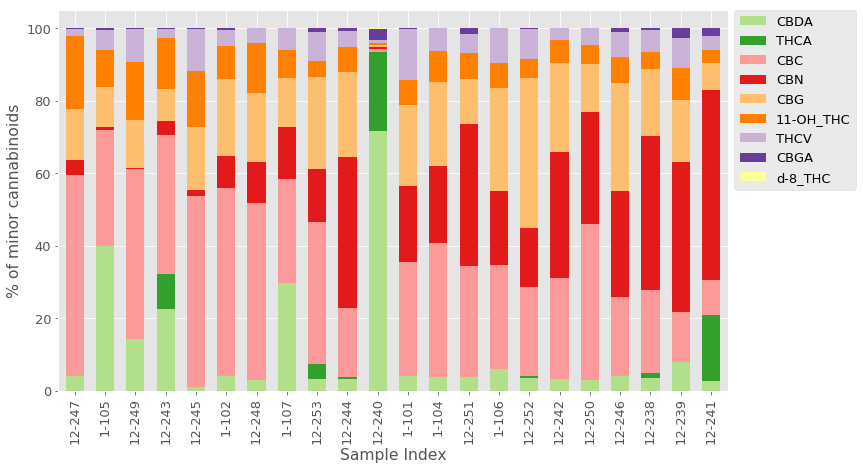

In [43]:
minor_HPLC_exp = HPLC_exp.iloc[:,2:].div(HPLC_exp.iloc[:,2:].sum(1), axis=0)

fig, ax = plt.subplots(1,1, figsize=(12, 7))
minor_HPLC_exp.plot(kind="bar", stacked=True, ax=ax, color=colors[2:], width = 0.6)
ax.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0.)
ax.set_xlabel("Sample Index")
ax.set_ylabel("% of minor cannabinoids")
ax.set_yticklabels([0, 20, 40, 60, 80, 100])
plt.show()

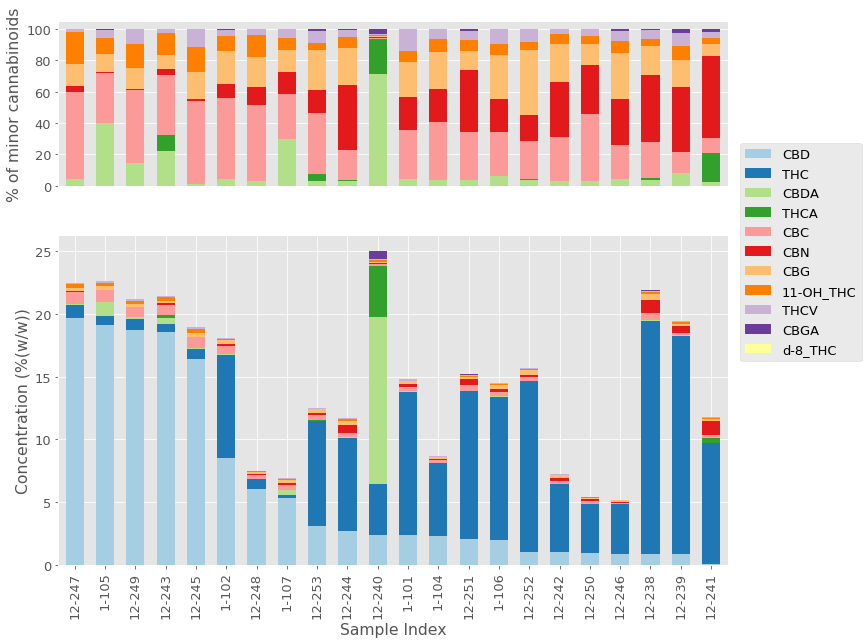

In [45]:
plt.rcParams.update({'font.size': 13})

fig, ax = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw = {'height_ratios':[1, 2]})

HPLC_exp.plot(kind="bar", stacked=True, ax=ax[1], color=colors, width = 0.6)
lgd = ax[1].legend(bbox_to_anchor=(1.21, 1.3))
ax[1].set_xlabel("Sample Index")
ax[1].set_ylabel("Concentration (%(w/w))")

minor_HPLC_exp = HPLC_exp.iloc[:,2:].div(HPLC_exp.iloc[:,2:].sum(1), axis=0)
minor_HPLC_exp.plot(kind="bar", stacked=True, ax=ax[0], color=colors[2:], width = 0.6)
ax[0].get_legend().remove()
ax[0].set_ylabel("% of minor cannabinoids")
ax[0].set_yticklabels([0, 20, 40, 60, 80, 100])
ax[0].axes.get_xaxis().set_visible(False)
# plt.show()
plt.savefig("HPLC_results-1.png", dpi=1000, bbox_inches='tight', facecolor="white")#, bbox_extra_artist=[lgd])